## <a href="https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b#:%E2%80%94:text=to%20this%20story%2C-,An%20End%2Dto%2DEnd%20Project%20on%20Time%20Series,Analysis%20%20and%20Forecasting%20with%20Python&text=Time%20series%20analysis%2%20Ocomprises%20methods,other%20characteristics%20of%20the%20data." target="_blank">Artigo</a>

## Tratamento de dados

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [2]:
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 13
matplotlib.rcParams['ytick.labelsize'] = 13
matplotlib.rcParams['text.color'] = 'k'

* Importar dados do arquivo
* Criar novo dataset onde os dados pertencem apenas à categoria "Furniture"

Obs: definir a variável "furniture" como um novo DataFrame, ao invés de 
continuar usando-a como um *slice* de "df" evita erros de [*chained indexing*](https://paulovasconcellos.com.br/o-que-%C3%A9-a-value-is-trying-to-be-set-on-a-copy-of-a-slice-from-a-dataframe-e85f744d8be1)

In [3]:
df = pd.read_excel("Superstore.xls")
furniture = pd.DataFrame(df.loc[df['Category'] == 'Furniture'])

In [4]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [5]:
furniture.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 9990
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         2121 non-null   int64         
 1   Order ID       2121 non-null   object        
 2   Order Date     2121 non-null   datetime64[ns]
 3   Ship Date      2121 non-null   datetime64[ns]
 4   Ship Mode      2121 non-null   object        
 5   Customer ID    2121 non-null   object        
 6   Customer Name  2121 non-null   object        
 7   Segment        2121 non-null   object        
 8   Country        2121 non-null   object        
 9   City           2121 non-null   object        
 10  State          2121 non-null   object        
 11  Postal Code    2121 non-null   int64         
 12  Region         2121 non-null   object        
 13  Product ID     2121 non-null   object        
 14  Category       2121 non-null   object        
 15  Sub-Category   2121 n

In [6]:
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


Colunas com dados que não serão importantes para a análise da série temporal, serão removidas.

In [7]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)

In [8]:
furniture.head()

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
3,2015-10-11,957.5775
5,2014-06-09,48.8600
10,2014-06-09,1706.1840


Verificar se existem valores *null* no dataset

In [9]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

Os valores serão ordenados de acordo com a "Order Date".

In [10]:
furniture = furniture.sort_values('Order Date')

Como os dados inicialmente não estavam ordenados por data, os índices ficaram desordenados, sendo necessário resetar o índice. <br>
Além disso os dados serão agrupados por data (somar os valores de "Sales" de uma mesma data e registrar numa única linha, eliminando repetições da coluna "Order Date").

In [11]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [12]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [13]:
furniture = furniture.set_index('Order Date')

In [14]:
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

"Os dados de data podem ser difíceis de trabalha, portanto, usaremos o valor médio das vendas diárias para aquele mês, e usaremos o início de cada mês como representação de data"<br>
A função ```.resample``` redimensiona o time series, *'MS'*, significa *month start*, ou seja, será usado o começo do mês como nova data, e utiliza-se o método ```.mean()``` para obter a média do mês.

In [15]:
y = furniture['Sales'].resample('MS').mean()

In [16]:
y

Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049188
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
2016-01-01     508.182867
2016-02-01     356.868273
2016-03-01     609.575810
2016-04-01     695.373158
2016-05-01     687.265227
2016-06-01     816.910750
2016-07-01     768.736412
2016-08-01     734.307782
2016-09-01    1135.953371
2016-10-01     624.872474
2016-11-01    1271.345152
2016-12-01    1410.719808
2017-01-01     397.602133
2017-02-01     528.179800
2

<AxesSubplot:xlabel='Order Date'>

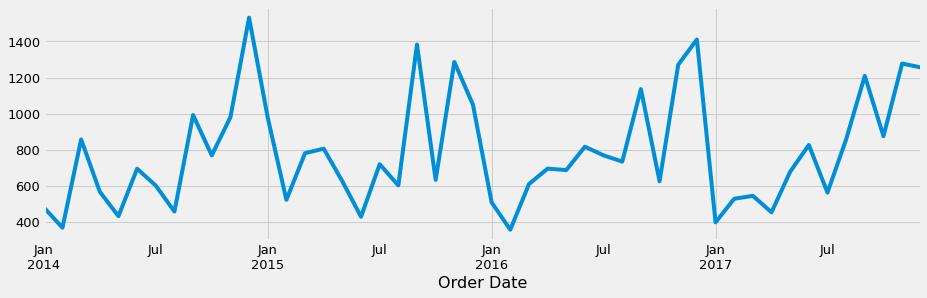

In [17]:
y.plot(figsize=(14,4))

Observa-se um certo padrão de aumento nas vendas nos meses finais do ano, com uma grande queda no início de um novo ano. As vendas variam um pouco ao longo dos primeiro semestre do do ano, voltando a crescer rapidamente no segundo semestre. 
___

## Decomposição de séries temporais
>" Uma decomposição clássica de séries temporais permite que a série seja escrita como uma soma ou multiplicação de componentes não observáveis. Assim, pode-se usar um modelo aditivo – quando se  supõe  que  os  componentes  da  série  temporal  são  somados  para  formar  os  dados – ou  um  modelo multiplicativo – que  supõe  que  os  componentes  são  multiplicados  um  pelo  outro."

* **Tendência:** As grandezas, em boa parte das vezes, apresentam uma tendência de comportamento em relação à  variável  tempo. Assim,  nesses  casos,  elas  revelam  um  comportamento  que tende a  ser  maior  (na maioria  das  vezes)   ou   menor  à   medida  que   o  tempo  passa.Essa  tendência,  normalmente,   é consequência do aumento da população e/ou da evolução tecnológica/científica, mas também pode ser fruto de outras causas, como o aumento gradativo da temperatura na Terra ou até mesmo de mudanças no comportamento cultural das sociedades.

* **Sazonalidade:** Explica  o  comportamento  cíclico  (ao  longo  de  um  ano  ou  intervalo  menor)  das  grandezas, muitas  vezes,sendo resultado de suas  variações  em função das  estações  do ano (por  exemplo: venda de  sorvetes,  consumo  de  energia  elétrica).  Nesses  casos,  o  padrão  de  sazonalidade  é  mensal  ou trimestral  ao  longo  do  ano. 

* **Resíduo (Componentes aleatórios):** Se  expurgarmos  os  efeitos  sazonais,  cíclicos  e  de  tendência  de  uma  série  que  revele  o comportamento  de  uma  grandeza  ao  longo  do  tempo,  o  restante  da  sua  variação  é  chamada  de flutuação residual e pode ser considerada como proveniente de componentes aleatórios. Essa flutuação residual também pode ser entendida como oriunda de situações indistinguíveis, já que a sazonalidade, a tendência e o ciclo foram encarados como situações distinguíveis.

[Fonte 1](http://www.anpad.org.br/periodicos/arq_pdf/a_1320.pdf) | [Fonte 2](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

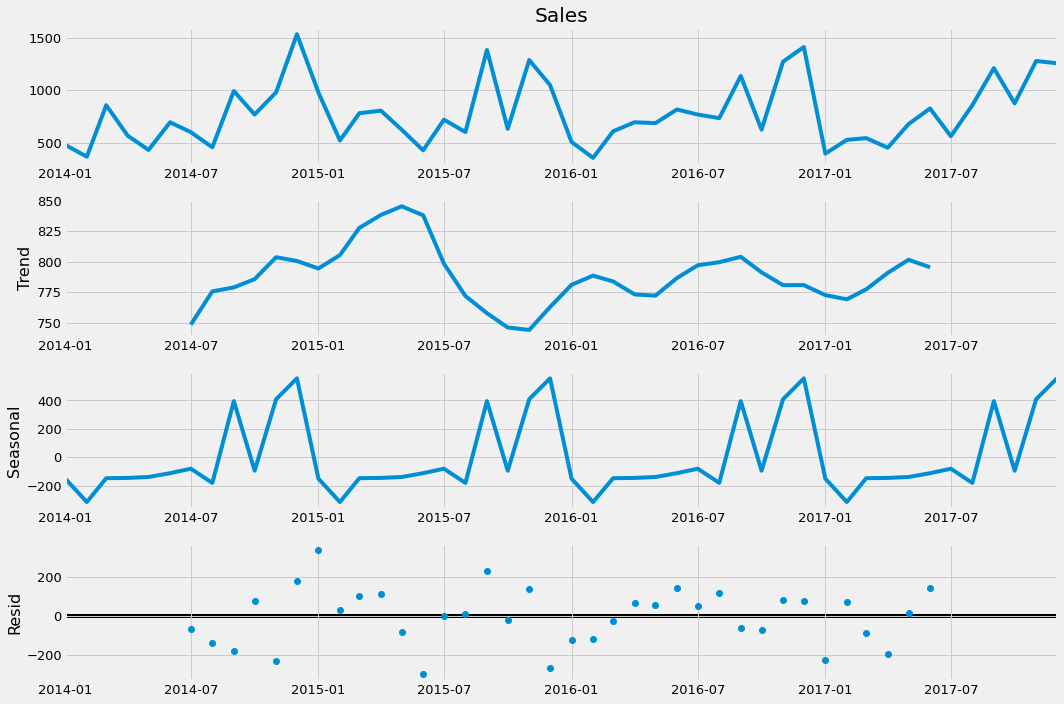

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Oberva-se que no longo prazo não há uma **tendência** clara nos dados, e existe uma instabilidade quanto ao crescimendo.<br>
Já a **sazonalidade** é bastante óbvia, com um grande aumento nas vendas no período final de cada ano, e então uma queda brusca no início do próximo ano.

In [19]:
from pycaret.regression import setup

reg = setup(data=y, target='Sales')

ModuleNotFoundError: No module named 'pycaret'